In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pathlib
import glob

2024-05-02 05:01:30.473430: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 05:01:30.473572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 05:01:30.586257: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [3]:
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageFilter
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
from multiprocessing import Pool
from tqdm import tqdm

data = []
class_folders = ['Mild', 'Moderate', 'Severe', 'Proliferate_DR', 'No_DR']
for label, folder in enumerate(class_folders):
    file_paths = glob.glob(f'/kaggle/input/custom-dr/COLOR_EYE/colored_images/{folder}/*.png')
    for file_path in file_paths:
        data.append({'file_path': file_path, 'label': label})

df = pd.DataFrame(data)

In [6]:
no_dr_data = df[df['label'] == 4]
other_data = df[df['label'] != 4]

In [7]:
images_needed_per_class = 5000 - other_data.groupby('label').size()
images_needed_per_class

label
0    4630
1    4001
2    4807
3    4705
dtype: int64

In [8]:
image_preset = no_dr_data.groupby('label').size()
image_preset

label
4    1805
dtype: int64

In [9]:
images_per_class = other_data.groupby('label').size()
images_per_class

label
0    370
1    999
2    193
3    295
dtype: int64

In [10]:
from PIL import Image
import numpy as np
from tqdm import tqdm
from skimage.transform import rotate
# np.random.seed(49)

import numpy as np

def apply_augmentation(image):
    augmented_images = []
    augmented_images.append(np.rot90(image, k=1, axes=(0, 1)))
    augmented_images.append(np.rot90(image, k=3, axes=(0, 1)))
    augmented_images.append(np.rot90(image, k=2, axes=(0, 1)))
    augmented_images.append(np.fliplr(image))
    augmented_images.append(np.flipud(image))

    
    return augmented_images


X_augmented = []
y_augmented = []

images_per_class = 5000 

for class_label, images_needed in images_needed_per_class.items():
    class_data = other_data[other_data['label'] == class_label]
    
    
    existing_images = [np.array(Image.open(file_path)) for file_path in class_data['file_path']]
    num_existing_images = len(existing_images)
   
    
    images_to_augment = images_per_class - num_existing_images
   
    X_augmented.extend(existing_images)
    y_augmented.extend([class_label] * num_existing_images)
   
  
    if images_to_augment > 0:
        num_iterations = images_to_augment // 5
        remainder = images_to_augment % 5
        
        for i in tqdm(range(num_iterations), desc=f"Augmenting class {class_label}"):  
       
            original_image = existing_images[np.random.randint(num_existing_images)]
            augmented_images = apply_augmentation(original_image)
            X_augmented.extend(augmented_images)
            y_augmented.extend([class_label] * len(augmented_images))
        
        for i in tqdm(range(remainder), desc=f"Augmenting class {class_label} (Extra)"):  
            original_image = existing_images[np.random.randint(num_existing_images)]
            augmented_images = apply_augmentation(original_image)
            for j in range(1):
                X_augmented.append(augmented_images[j])
                y_augmented.append(class_label)



X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

print("Augmentation complete.")

Augmenting class 0: 100%|██████████| 926/926 [00:00<00:00, 9015.21it/s]
Augmenting class 0 (Extra): 0it [00:00, ?it/s]
Augmenting class 3: 100%|██████████| 941/941 [00:00<00:00, 10259.87it/s]
Augmenting class 3 (Extra): 0it [00:00, ?it/s]


Augmentation complete.


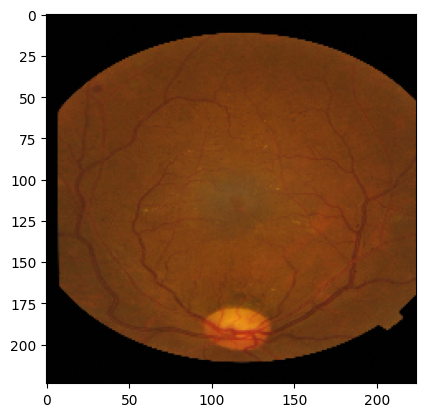

In [9]:
import matplotlib.pyplot as plt

def display_augmented_images(images, num_images=5):
    image = images[1196]
    plt.imshow(image)
    plt.show()

display_augmented_images(X_augmented, num_images=1)

In [11]:
print("Length of X_augmented:", X_augmented.shape)
print("Length of y_augmented:", len(y_augmented))

Length of X_augmented: (20000, 224, 224, 3)
Length of y_augmented: 20000


In [12]:
images_per_class = 5000

existing_images = []

for class_label, images_needed in image_preset.items():
    
    class_data_no_dr = no_dr_data[no_dr_data['label'] == class_label]
    existing_images = [np.array(Image.open(file_path)) for file_path in class_data_no_dr['file_path']]
    
    num_existing_images = len(existing_images)
   
    
    images_to_augment = images_per_class - num_existing_images
   

    if images_to_augment > 0:
        num_iterations = images_to_augment // 5
        remainder = images_to_augment % 5
        
        for i in tqdm(range(num_iterations), desc=f"Augmenting class {class_label}"):  
       
            original_image = existing_images[np.random.randint(num_existing_images)]
            augmented_images = apply_augmentation(original_image)
            existing_images.extend(augmented_images)
        
        for i in tqdm(range(remainder), desc=f"Augmenting class {class_label} (Extra)"):  
            original_image = existing_images[np.random.randint(num_existing_images)]
            augmented_images = apply_augmentation(original_image)
            for j in range(1):
                existing_images.append(augmented_images[j])
               



            
            
Dr_images = np.array(existing_images)
Dr_images.shape

Augmenting class 4: 100%|██████████| 639/639 [00:00<00:00, 13974.96it/s]
Augmenting class 4 (Extra): 0it [00:00, ?it/s]


(5000, 224, 224, 3)

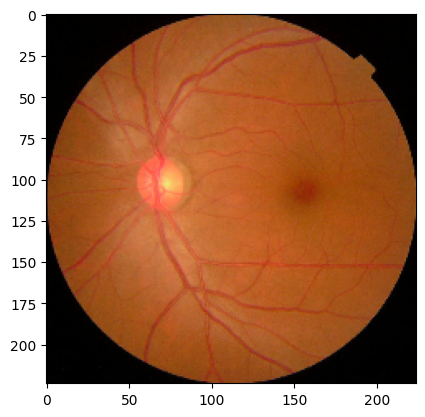

In [22]:
import matplotlib.pyplot as plt

def display_augmented_images(images, num_images=5):
    image = images[500]
    plt.imshow(image)
    plt.show()

display_augmented_images(Dr_images, num_images=1)

In [13]:
import numpy as np
from skimage.restoration import denoise_tv_chambolle
import cv2

def denoise_and_gamma_correction(image, gamma=1.1,kernel_size=1):
    sigmaX = 10
    
    gamma_corrected_image = np.power(image , gamma)
    gamma_corrected_image = np.clip(gamma_corrected_image, 0, 255)
    gamma_corrected_image = gamma_corrected_image.astype(np.uint8)
    image=cv2.addWeighted ( gamma_corrected_image,4, cv2.GaussianBlur( gamma_corrected_image , (0,0) , sigmaX) ,-4 ,128)
    
    return image

In [14]:
from multiprocessing import Pool
from tqdm import tqdm

def preprocess_image(image):
    preprocessed_image = denoise_and_gamma_correction(image)
    return preprocessed_image

def preprocess_chunk(chunk):
    with Pool() as pool:
        preprocessed_images = list(tqdm(pool.imap(preprocess_image, chunk), total=len(chunk), desc="Preprocessing images"))
    return preprocessed_images

full_image = np.concatenate((X_augmented, Dr_images), axis=0)


chunk_size = 500 
chunks = [full_image[i:i+chunk_size] for i in range(0, len(full_image), chunk_size)]

preprocessed_chunks = [preprocess_chunk(chunk) for chunk in chunks]

denoised_gamma_corrected_images = np.concatenate(preprocessed_chunks)

image_label = np.concatenate((y_augmented, np.full(len(Dr_images), class_label)), axis=0)

Preprocessing images: 100%|██████████| 500/500 [00:06<00:00, 82.93it/s]


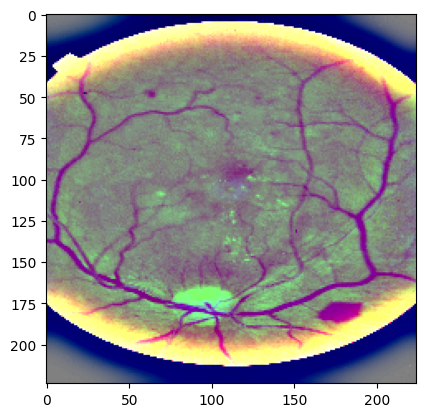

In [13]:
import matplotlib.pyplot as plt

def display_augmented_images(images, num_images=5):
    image = images[400]
    plt.imshow(image)
    plt.show()

display_augmented_images(denoised_gamma_corrected_images, num_images=1)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(denoised_gamma_corrected_images , image_label, test_size=0.2, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=True)

print("Train Set:", len(X_train))
print("Validation Set:", len(X_val))
print("Test Set:", len(X_test))

Train Set: 20000
Validation Set: 2500
Test Set: 2500


In [17]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


base_model =  ResNet50(weights="imagenet",include_top=False,input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(32, activation= 'relu'),
    Dropout(0.1),
    Dense(5, activation= 'softmax')
])

In [15]:
from tensorflow.keras.callbacks import Callback
class MetricsCallback(Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()
        self.train_metrics = {'accuracy': [], 'loss': []}
        self.val_metrics = {'accuracy': [], 'loss': []}

    def on_epoch_end(self, epoch, logs=None):
        self.train_metrics['accuracy'].append(logs.get('accuracy'))
        self.train_metrics['loss'].append(logs.get('loss'))
        self.val_metrics['accuracy'].append(logs.get('val_accuracy'))
        self.val_metrics['loss'].append(logs.get('val_loss'))

metrics_callback = MetricsCallback()

In [20]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size = 16,
                    validation_data=(X_val, y_val),
                    callbacks=[metrics_callback])

loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
    
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
report = classification_report(y_test, predicted_labels)
print("Classification Report:\n", report)

Epoch 1/20
   2/1250 ━━━━━━━━━━━━━━━━━━━━ 1:31 73ms/step - accuracy: 0.1719 - loss: 3.9659  

I0000 00:00:1714585155.885716    6352 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714585155.944169    6352 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3693 - loss: 1.4325

W0000 00:00:1714585215.002373    6352 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 56ms/step - accuracy: 0.3693 - loss: 1.4324 - val_accuracy: 0.3940 - val_loss: 1.3094
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 63s 50ms/step - accuracy: 0.4150 - loss: 1.2668 - val_accuracy: 0.5076 - val_loss: 1.1962
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 62s 50ms/step - accuracy: 0.5045 - loss: 1.1729 - val_accuracy: 0.5568 - val_loss: 1.0660
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 63s 50ms/step - accuracy: 0.5556 - loss: 1.0495 - val_accuracy: 0.6364 - val_loss: 0.8760
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 63s 50ms/step - accuracy: 0.6346 - loss: 0.8430 - val_accuracy: 0.6832 - val_loss: 0.7268
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 62s 50ms/step - accuracy: 0.6617 - loss: 0.7507 - val_accuracy: 0.6928 - val_loss: 0.6838
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 63s 50ms/step - accuracy: 0.6994 - loss: 0.6732 - val_accuracy: 0.7580 - val_loss: 0.6208
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 63s 50ms/step - accuracy: 0.7316 - loss: 0.62

In [23]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import precision_recall_curve

y_pred_probs = model.predict(X_test)
y_true = y_test


y_pred = np.argmax(y_pred_probs, axis=1)

precisions = []
recalls = []
class_names = ['Mild', 'Moderate', 'No_DR', 'Severe', 'Proliferate_DR'] # Update with your class names

for class_idx in range(len(class_names)):
    y_true_class = (y_true == class_idx).astype(int)
    y_pred_class = (y_pred == class_idx).astype(int)
    precision, recall, _ = precision_recall_curve(y_true_class, y_pred_probs[:, class_idx])
    precisions.append(precision)
    recalls.append(recall)

fig = go.Figure()

for class_idx in range(len(class_names)):
    fig.add_trace(go.Scatter(x=recalls[class_idx], y=precisions[class_idx], mode='lines', name=class_names[class_idx]))

# Customize layout
fig.update_layout(
    title='Precision-Recall Curve (Multiclass)',
    xaxis_title='Recall',
    yaxis_title='Precision'
)

# Show the plot
fig.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step


In [24]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_true =  y_test

conf_matrix = confusion_matrix(y_true, np.argmax(y_pred,axis=1))

class_names =['Mild', 'Moderate', 'No_DR', 'Severe', 'Proliferate_DR']

fig = go.Figure(data=go.Heatmap(z=conf_matrix, x=class_names, y=class_names, colorscale='YlGnBu'))

fig.update_layout(
    title='Confusion Matrix',
    xaxis_title='Predicted label',
    yaxis_title='True label'
)

fig.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step


In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


base_model = VGG16(weights="imagenet",include_top=False,input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(32, activation= 'relu'),
    Dropout(0.1),
    Dense(5, activation= 'softmax')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
from tensorflow.keras.callbacks import Callback
class MetricsCallback(Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()
        self.train_metrics = {'accuracy': [], 'loss': []}
        self.val_metrics = {'accuracy': [], 'loss': []}

    def on_epoch_end(self, epoch, logs=None):
        self.train_metrics['accuracy'].append(logs.get('accuracy'))
        self.train_metrics['loss'].append(logs.get('loss'))
        self.val_metrics['accuracy'].append(logs.get('val_accuracy'))
        self.val_metrics['loss'].append(logs.get('val_loss'))

metrics_callback = MetricsCallback()

In [17]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size = 16,
                    validation_data=(X_val, y_val),
                    callbacks=[metrics_callback])

loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
    
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
report = classification_report(y_test, predicted_labels)
print("Classification Report:\n", report)

Epoch 1/20
   2/1250 ━━━━━━━━━━━━━━━━━━━━ 1:32 74ms/step - accuracy: 0.1562 - loss: 14.4315  

I0000 00:00:1714582251.997679    4768 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714582252.022560    4768 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3896 - loss: 1.8869

W0000 00:00:1714582332.962278    4770 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 119s 78ms/step - accuracy: 0.3897 - loss: 1.8865 - val_accuracy: 0.5584 - val_loss: 0.9834
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 91s 73ms/step - accuracy: 0.5391 - loss: 0.9658 - val_accuracy: 0.6356 - val_loss: 0.8107
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 90s 72ms/step - accuracy: 0.6398 - loss: 0.7861 - val_accuracy: 0.6992 - val_loss: 0.7215
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 91s 72ms/step - accuracy: 0.7007 - loss: 0.6709 - val_accuracy: 0.7784 - val_loss: 0.5776
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 91s 72ms/step - accuracy: 0.7304 - loss: 0.6080 - val_accuracy: 0.7988 - val_loss: 0.5268
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 90s 72ms/step - accuracy: 0.7677 - loss: 0.5333 - val_accuracy: 0.8164 - val_loss: 0.4893
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 90s 72ms/step - accuracy: 0.7882 - loss: 0.4878 - val_accuracy: 0.8212 - val_loss: 0.4774
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 90s 72ms/step - accuracy: 0.8040 - loss: 0.4

W0000 00:00:1714584101.480153    4768 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 124ms/step - accuracy: 0.8690 - loss: 0.4877
Test Accuracy: 0.8784000277519226
 2/79 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step 

W0000 00:00:1714584113.002200    4770 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       517
           1       0.85      0.70      0.77       486
           2       0.81      0.95      0.88       482
           3       0.87      0.86      0.86       501
           4       0.95      0.97      0.96       514

    accuracy                           0.88      2500
   macro avg       0.88      0.88      0.88      2500
weighted avg       0.88      0.88      0.88      2500



In [19]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import precision_recall_curve

y_pred_probs = model.predict(X_test)
y_true = y_test


y_pred = np.argmax(y_pred_probs, axis=1)

precisions = []
recalls = []
class_names = ['Mild', 'Moderate', 'No_DR', 'Severe', 'Proliferate_DR'] # Update with your class names

for class_idx in range(len(class_names)):
    y_true_class = (y_true == class_idx).astype(int)
    y_pred_class = (y_pred == class_idx).astype(int)
    precision, recall, _ = precision_recall_curve(y_true_class, y_pred_probs[:, class_idx])
    precisions.append(precision)
    recalls.append(recall)

fig = go.Figure()

for class_idx in range(len(class_names)):
    fig.add_trace(go.Scatter(x=recalls[class_idx], y=precisions[class_idx], mode='lines', name=class_names[class_idx]))

# Customize layout
fig.update_layout(
    title='Precision-Recall Curve (Multiclass)',
    xaxis_title='Recall',
    yaxis_title='Precision'
)

# Show the plot
fig.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step


In [20]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_true =  y_test

conf_matrix = confusion_matrix(y_true, np.argmax(y_pred,axis=1))

class_names =['Mild', 'Moderate', 'No_DR', 'Severe', 'Proliferate_DR']

fig = go.Figure(data=go.Heatmap(z=conf_matrix, x=class_names, y=class_names, colorscale='YlGnBu'))

fig.update_layout(
    title='Confusion Matrix',
    xaxis_title='Predicted label',
    yaxis_title='True label'
)

fig.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step


In [33]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


base_model = VGG19(weights="imagenet",include_top=False,input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation= 'relu'),
    Dropout(0.3),
    Dense(5, activation= 'softmax')
])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [34]:
from tensorflow.keras.callbacks import Callback
class MetricsCallback(Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()
        self.train_metrics = {'accuracy': [], 'loss': []}
        self.val_metrics = {'accuracy': [], 'loss': []}

    def on_epoch_end(self, epoch, logs=None):
        self.train_metrics['accuracy'].append(logs.get('accuracy'))
        self.train_metrics['loss'].append(logs.get('loss'))
        self.val_metrics['accuracy'].append(logs.get('val_accuracy'))
        self.val_metrics['loss'].append(logs.get('val_loss'))

metrics_callback = MetricsCallback()

In [35]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [36]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size = 16,
                    validation_data=(X_val, y_val),
                    callbacks=[metrics_callback])

loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
    
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
report = classification_report(y_test, predicted_labels)
print("Classification Report:\n", report)

Epoch 1/20
   2/1250 ━━━━━━━━━━━━━━━━━━━━ 1:43 83ms/step - accuracy: 0.1719 - loss: 23.9898  

W0000 00:00:1714577902.764677    1079 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4975 - loss: 3.2987

W0000 00:00:1714578004.601622    1082 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 97ms/step - accuracy: 0.4975 - loss: 3.2973 - val_accuracy: 0.6984 - val_loss: 0.7962
Epoch 2/20
   2/1250 ━━━━━━━━━━━━━━━━━━━━ 1:39 80ms/step - accuracy: 0.7344 - loss: 0.6638

W0000 00:00:1714578023.359583    1080 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 112s 90ms/step - accuracy: 0.6690 - loss: 0.8087 - val_accuracy: 0.7808 - val_loss: 0.6551
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 112s 90ms/step - accuracy: 0.7347 - loss: 0.6511 - val_accuracy: 0.8064 - val_loss: 0.5474
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 112s 89ms/step - accuracy: 0.7804 - loss: 0.5495 - val_accuracy: 0.8520 - val_loss: 0.4648
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 89ms/step - accuracy: 0.8087 - loss: 0.4627 - val_accuracy: 0.8600 - val_loss: 0.4448
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 112s 89ms/step - accuracy: 0.8302 - loss: 0.4146 - val_accuracy: 0.8728 - val_loss: 0.4229
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 112s 89ms/step - accuracy: 0.8494 - loss: 0.3748 - val_accuracy: 0.8752 - val_loss: 0.4046
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 113s 90ms/step - accuracy: 0.8605 - loss: 0.3295 - val_accuracy: 0.8820 - val_loss: 0.4098
Epoch 9/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 112s 90ms/step - accuracy: 0.8718 - lo

W0000 00:00:1714580218.283471    1082 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 43s 149ms/step - accuracy: 0.9087 - loss: 0.4434
Test Accuracy: 0.9031999707221985
 2/79 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step

W0000 00:00:1714580231.662980    1079 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89       517
           1       0.84      0.80      0.82       486
           2       0.92      0.95      0.93       482
           3       0.93      0.90      0.91       501
           4       0.96      0.95      0.95       514

    accuracy                           0.90      2500
   macro avg       0.90      0.90      0.90      2500
weighted avg       0.90      0.90      0.90      2500



W0000 00:00:1714580244.005759    1082 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [37]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import precision_recall_curve

y_pred_probs = model.predict(X_test)
y_true = y_test


y_pred = np.argmax(y_pred_probs, axis=1)

precisions = []
recalls = []
class_names = ['Mild', 'Moderate', 'No_DR', 'Severe', 'Proliferate_DR'] # Update with your class names

for class_idx in range(len(class_names)):
    y_true_class = (y_true == class_idx).astype(int)
    y_pred_class = (y_pred == class_idx).astype(int)
    precision, recall, _ = precision_recall_curve(y_true_class, y_pred_probs[:, class_idx])
    precisions.append(precision)
    recalls.append(recall)

fig = go.Figure()

for class_idx in range(len(class_names)):
    fig.add_trace(go.Scatter(x=recalls[class_idx], y=precisions[class_idx], mode='lines', name=class_names[class_idx]))

# Customize layout
fig.update_layout(
    title='Precision-Recall Curve (Multiclass)',
    xaxis_title='Recall',
    yaxis_title='Precision'
)

# Show the plot
fig.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step


In [38]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_true =  y_test

conf_matrix = confusion_matrix(y_true, np.argmax(y_pred,axis=1))

class_names =['Mild', 'Moderate', 'No_DR', 'Severe', 'Proliferate_DR']

fig = go.Figure(data=go.Heatmap(z=conf_matrix, x=class_names, y=class_names, colorscale='YlGnBu'))

fig.update_layout(
    title='Confusion Matrix',
    xaxis_title='Predicted label',
    yaxis_title='True label'
)

fig.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step


In [26]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


base_model = MobileNet(weights="imagenet",include_top=False,input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation= 'relu'),
    Dropout(0.3),
    Dense(5, activation= 'softmax')
])

In [27]:
from tensorflow.keras.callbacks import Callback
class MetricsCallback(Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()
        self.train_metrics = {'accuracy': [], 'loss': []}
        self.val_metrics = {'accuracy': [], 'loss': []}

    def on_epoch_end(self, epoch, logs=None):
        self.train_metrics['accuracy'].append(logs.get('accuracy'))
        self.train_metrics['loss'].append(logs.get('loss'))
        self.val_metrics['accuracy'].append(logs.get('val_accuracy'))
        self.val_metrics['loss'].append(logs.get('val_loss'))

metrics_callback = MetricsCallback()

In [28]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size = 16,
                    validation_data=(X_val, y_val),
                    callbacks=[metrics_callback])

loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
    
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
report = classification_report(y_test, predicted_labels)
print("Classification Report:\n", report)

Epoch 1/20
   7/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.3115 - loss: 3.5008

W0000 00:00:1714577223.966244    1081 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4533 - loss: 1.3651

W0000 00:00:1714577247.634104    1079 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4534 - loss: 1.3650 - val_accuracy: 0.6228 - val_loss: 1.0140
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.5869 - loss: 0.9893 - val_accuracy: 0.6820 - val_loss: 0.8619
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.6675 - loss: 0.8336 - val_accuracy: 0.7048 - val_loss: 0.7781
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.7085 - loss: 0.7322 - val_accuracy: 0.7320 - val_loss: 0.7280
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.7409 - loss: 0.6436 - val_accuracy: 0.7812 - val_loss: 0.6422
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.7814 - loss: 0.5619 - val_accuracy: 0.8060 - val_loss: 0.5708
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8043 - loss: 0.4985 - val_accuracy: 0.8372 - val_loss: 0.5126
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8272 - loss: 0.44

W0000 00:00:1714577702.626712    1079 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8956 - loss: 0.4572
Test Accuracy: 0.8895999789237976
 7/79 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step

W0000 00:00:1714577707.091018    1082 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89       517
           1       0.78      0.78      0.78       486
           2       0.93      0.94      0.94       482
           3       0.91      0.89      0.90       501
           4       0.94      0.94      0.94       514

    accuracy                           0.89      2500
   macro avg       0.89      0.89      0.89      2500
weighted avg       0.89      0.89      0.89      2500



In [30]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import precision_recall_curve

y_pred_probs = model.predict(X_test)
y_true = y_test


y_pred = np.argmax(y_pred_probs, axis=1)

precisions = []
recalls = []
class_names = ['Mild', 'Moderate', 'No_DR', 'Severe', 'Proliferate_DR'] # Update with your class names

for class_idx in range(len(class_names)):
    y_true_class = (y_true == class_idx).astype(int)
    y_pred_class = (y_pred == class_idx).astype(int)
    precision, recall, _ = precision_recall_curve(y_true_class, y_pred_probs[:, class_idx])
    precisions.append(precision)
    recalls.append(recall)

fig = go.Figure()

for class_idx in range(len(class_names)):
    fig.add_trace(go.Scatter(x=recalls[class_idx], y=precisions[class_idx], mode='lines', name=class_names[class_idx]))

# Customize layout
fig.update_layout(
    title='Precision-Recall Curve (Multiclass)',
    xaxis_title='Recall',
    yaxis_title='Precision'
)

# Show the plot
fig.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


In [31]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_true =  y_test

conf_matrix = confusion_matrix(y_true, np.argmax(y_pred,axis=1))

class_names =['Mild', 'Moderate', 'No_DR', 'Severe', 'Proliferate_DR']

fig = go.Figure(data=go.Heatmap(z=conf_matrix, x=class_names, y=class_names, colorscale='YlGnBu'))

fig.update_layout(
    title='Confusion Matrix',
    xaxis_title='Predicted label',
    yaxis_title='True label'
)

fig.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


In [25]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


base_model = MobileNet(weights="imagenet",include_top=False,input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation= 'relu'),
    Dropout(0.3),
    Dense(5, activation= 'softmax')
])

In [18]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


base_model = MobileNet(weights="imagenet",include_top=False,input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation= 'relu'),
    Dropout(0.3),
    Dense(5, activation= 'softmax')
])

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [19]:
from tensorflow.keras.callbacks import Callback
class MetricsCallback(Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()
        self.train_metrics = {'accuracy': [], 'loss': []}
        self.val_metrics = {'accuracy': [], 'loss': []}

    def on_epoch_end(self, epoch, logs=None):
        self.train_metrics['accuracy'].append(logs.get('accuracy'))
        self.train_metrics['loss'].append(logs.get('loss'))
        self.val_metrics['accuracy'].append(logs.get('val_accuracy'))
        self.val_metrics['loss'].append(logs.get('val_loss'))

metrics_callback = MetricsCallback()

In [20]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size = 16,
                    validation_data=(X_val, y_val),
                    callbacks=[metrics_callback])

loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
    
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
report = classification_report(y_test, predicted_labels)
print("Classification Report:\n", report)

Epoch 1/20
   6/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.2330 - loss: 4.0692 

I0000 00:00:1714576464.909210    1081 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714576464.940899    1081 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4235 - loss: 1.4810

W0000 00:00:1714576487.648731    1079 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - accuracy: 0.4235 - loss: 1.4806 - val_accuracy: 0.6312 - val_loss: 0.9846
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.5796 - loss: 1.0017 - val_accuracy: 0.6252 - val_loss: 0.9323
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.6575 - loss: 0.8523 - val_accuracy: 0.6924 - val_loss: 0.8438
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.6906 - loss: 0.7642 - val_accuracy: 0.7616 - val_loss: 0.6878
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.7423 - loss: 0.6543 - val_accuracy: 0.7716 - val_loss: 0.6310
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.7609 - loss: 0.5976 - val_accuracy: 0.7988 - val_loss: 0.5755
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.8013 - loss: 0.5161 - val_accuracy: 0.8368 - val_loss: 0.5213
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8095 - loss: 0.48

W0000 00:00:1714576944.774194    1080 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8823 - loss: 0.5149
Test Accuracy: 0.8751999735832214
 7/79 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step

W0000 00:00:1714576949.375861    1080 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85       517
           1       0.79      0.73      0.76       486
           2       0.95      0.93      0.94       482
           3       0.91      0.88      0.89       501
           4       0.94      0.91      0.93       514

    accuracy                           0.88      2500
   macro avg       0.88      0.87      0.87      2500
weighted avg       0.88      0.88      0.88      2500



In [22]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import precision_recall_curve

y_pred_probs = model.predict(X_test)
y_true = y_test


y_pred = np.argmax(y_pred_probs, axis=1)

precisions = []
recalls = []
class_names = ['Mild', 'Moderate', 'No_DR', 'Severe', 'Proliferate_DR'] # Update with your class names

for class_idx in range(len(class_names)):
    y_true_class = (y_true == class_idx).astype(int)
    y_pred_class = (y_pred == class_idx).astype(int)
    precision, recall, _ = precision_recall_curve(y_true_class, y_pred_probs[:, class_idx])
    precisions.append(precision)
    recalls.append(recall)

fig = go.Figure()

for class_idx in range(len(class_names)):
    fig.add_trace(go.Scatter(x=recalls[class_idx], y=precisions[class_idx], mode='lines', name=class_names[class_idx]))

# Customize layout
fig.update_layout(
    title='Precision-Recall Curve (Multiclass)',
    xaxis_title='Recall',
    yaxis_title='Precision'
)

# Show the plot
fig.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


In [23]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_true =  y_test

conf_matrix = confusion_matrix(y_true, np.argmax(y_pred,axis=1))

class_names =['Mild', 'Moderate', 'No_DR', 'Severe', 'Proliferate_DR']

fig = go.Figure(data=go.Heatmap(z=conf_matrix, x=class_names, y=class_names, colorscale='YlGnBu'))

fig.update_layout(
    title='Confusion Matrix',
    xaxis_title='Predicted label',
    yaxis_title='True label'
)

fig.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


In [16]:
from tensorflow.keras.callbacks import Callback
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        print("call")
        if(logs.get('accuracy') > .99):
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(99))
            self.model.stop_training = True
callbacks = myCallback()

In [17]:
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adamax,Adagrad
def model_complile(learning_rate,model,optimizer):
    initial_learning_rate = learning_rate
    optimizer = optimizer(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import precision_recall_curve

def pre_vs_recall(model):
    y_pred_probs = model.predict(X_test)
    y_true = y_test
    
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    precisions = []
    recalls = []
    
    class_names = ['Mild', 'Moderate', 'No_DR', 'Severe', 'Proliferate_DR'] # Update with your class names

    for class_idx in range(len(class_names)):
        y_true_class = (y_true == class_idx).astype(int)
        y_pred_class = (y_pred == class_idx).astype(int)
        precision, recall, _ = precision_recall_curve(y_true_class, y_pred_probs[:, class_idx])
        precisions.append(precision)
        recalls.append(recall)
    
    fig = go.Figure()
    
    for class_idx in range(len(class_names)):
        fig.add_trace(go.Scatter(x=recalls[class_idx], y=precisions[class_idx], mode='lines', name=class_names[class_idx]))

        
        fig.update_layout(
            title='Precision-Recall Curve (Multiclass)',
            xaxis_title='Recall',
            yaxis_title='Precision')
    fig.show()
    

In [19]:
def Confusion_matrix(model):
    y_pred = model.predict(X_test)
    y_true =  y_test

    conf_matrix = confusion_matrix(y_true, np.argmax(y_pred,axis=1))
    class_names =['Mild', 'Moderate', 'No_DR', 'Severe', 'Proliferate_DR']
        
    fig = go.Figure(data=go.Heatmap(z=conf_matrix, x=class_names, y=class_names, colorscale='YlGnBu'))
        
    fig.update_layout(
            title='Confusion Matrix',
            xaxis_title='Predicted label',
            yaxis_title='True label'
        )
    fig.show()

In [20]:
from sklearn.metrics import classification_report
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import precision_recall_curve

import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def model_fit(model,epoch):
    history = model.fit(X_train, y_train,
                    epochs=epoch,
                    batch_size = 16,
                    validation_data=(X_val, y_val),
                    callbacks=[callbacks])
    
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Test Accuracy:", accuracy)
    
#     model.save("model.h5")
    
    predictions = model.predict(X_test)
    predicted_labels = np.argmax(predictions, axis=1)
    report = classification_report(y_test, predicted_labels)
    print("Classification Report:\n", report)
    
    pre_vs_recall(model)
    
    Confusion_matrix(model)
    


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

learning_rate = 0.0001
def custom_model(optimizer,hidden_activation,output_activation,num_classes,epoch):
    model = Sequential([
    Conv2D(32, (3, 3), activation=hidden_activation, input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation=hidden_activation),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation=hidden_activation),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation=hidden_activation),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation=hidden_activation),
    MaxPooling2D((2, 2)),  
    Flatten(),
    Dense(2048, activation=hidden_activation),
    Dropout(0.5), 
    Dense(1024, activation=hidden_activation),
    Dropout(0.5),
    Dense(num_classes, activation=output_activation)  
    ])
    
    model_complile(learning_rate,model,optimizer)
        
    model_fit(model,epoch)

In [25]:
epoch =30
num_classes = 5
custom_model(Adam,"relu","softmax",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30
   2/1250 ━━━━━━━━━━━━━━━━━━━━ 1:04 51ms/step - accuracy: 0.2031 - loss: 2.0510  

I0000 00:00:1714485787.936639    1077 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714485787.959605    1077 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4384 - loss: 1.3096

W0000 00:00:1714485830.186541    1080 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 73s 36ms/step - accuracy: 0.4385 - loss: 1.3095 - val_accuracy: 0.6464 - val_loss: 0.8833
Epoch 2/30
   5/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.6192 - loss: 0.8908

W0000 00:00:1714485832.862424    1077 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6616 - loss: 0.8380call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.6617 - loss: 0.8379 - val_accuracy: 0.7840 - val_loss: 0.5716
Epoch 3/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8251 - loss: 0.4681call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.8251 - loss: 0.4681 - val_accuracy: 0.8316 - val_loss: 0.4730
Epoch 4/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9160 - loss: 0.2469call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.9160 - loss: 0.2469 - val_accuracy: 0.8760 - val_loss: 0.3976
Epoch 5/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9550 - loss: 0.1553call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.9550 - loss: 0.1553 - val_accuracy: 0.8904 - val_loss: 0.3514
Epoch 6/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9683 - loss: 0.1113call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.968

W0000 00:00:1714487135.352724    1078 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9164 - loss: 0.5535
Test Accuracy: 0.9143999814987183
14/79 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

W0000 00:00:1714487137.925175    1080 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


W0000 00:00:1714487139.366186    1080 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       517
           1       0.85      0.82      0.83       486
           2       0.93      0.95      0.94       482
           3       0.91      0.89      0.90       501
           4       0.97      0.98      0.97       514

    accuracy                           0.91      2500
   macro avg       0.91      0.91      0.91      2500
weighted avg       0.91      0.91      0.91      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [36]:
from keras.applications import EfficientNetB0

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


base_model =  EfficientNetB0(weights="imagenet",include_top=False,input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation= 'relu'),
    Dropout(0.4),
    Dense(5, activation= 'softmax')
])


In [37]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.0001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [38]:
from tensorflow.keras.callbacks import Callback
class MetricsCallback(Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()
        self.train_metrics = {'accuracy': [], 'loss': []}
        self.val_metrics = {'accuracy': [], 'loss': []}

    def on_epoch_end(self, epoch, logs=None):
        self.train_metrics['accuracy'].append(logs.get('accuracy'))
        self.train_metrics['loss'].append(logs.get('loss'))
        self.val_metrics['accuracy'].append(logs.get('val_accuracy'))
        self.val_metrics['loss'].append(logs.get('val_loss'))

metrics_callback = MetricsCallback()

In [39]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size = 16,
                    validation_data=(X_val, y_val),
                    callbacks=[metrics_callback])

loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
    
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
report = classification_report(y_test, predicted_labels)
print("Classification Report:\n", report)

Epoch 1/20
   2/1250 ━━━━━━━━━━━━━━━━━━━━ 1:06 53ms/step - accuracy: 0.1406 - loss: 4.9202   

I0000 00:00:1714548007.929004    1105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714548007.984249    1105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5787 - loss: 1.2855

W0000 00:00:1714548060.557184    1105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 102s 50ms/step - accuracy: 0.5788 - loss: 1.2853 - val_accuracy: 0.7648 - val_loss: 0.6269
Epoch 2/20
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 56s 45ms/step - accuracy: 0.7396 - loss: 0.5645 

W0000 00:00:1714548070.659411    1107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.7646 - loss: 0.6091 - val_accuracy: 0.8076 - val_loss: 0.5002
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.8104 - loss: 0.4900 - val_accuracy: 0.8568 - val_loss: 0.4155
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 39ms/step - accuracy: 0.8573 - loss: 0.3918 - val_accuracy: 0.8744 - val_loss: 0.3651
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.8769 - loss: 0.3322 - val_accuracy: 0.8920 - val_loss: 0.3333
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.8977 - loss: 0.2800 - val_accuracy: 0.8920 - val_loss: 0.3085
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 39ms/step - accuracy: 0.9048 - loss: 0.2556 - val_accuracy: 0.9056 - val_loss: 0.2927
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.9193 - loss: 0.2268 - val_accuracy: 0.9120 - val_loss: 0.2783
Epoch 9/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.9241 - loss: 0.20

W0000 00:00:1714549036.019018    1105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.9245 - loss: 0.2620
Test Accuracy: 0.9300000071525574
 5/79 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step

W0000 00:00:1714549046.070657    1105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       517
           1       0.90      0.84      0.87       486
           2       0.94      0.96      0.95       482
           3       0.94      0.91      0.92       501
           4       0.97      0.97      0.97       514

    accuracy                           0.93      2500
   macro avg       0.93      0.93      0.93      2500
weighted avg       0.93      0.93      0.93      2500



W0000 00:00:1714549054.804906    1108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [33]:
epoch =30
num_classes = 5
custom_model(Adam,"relu","softmax",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30
   2/1250 ━━━━━━━━━━━━━━━━━━━━ 1:04 52ms/step - accuracy: 0.0781 - loss: 1.8622   

I0000 00:00:1714550745.336595    3743 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714550745.357374    3743 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4334 - loss: 1.3121

W0000 00:00:1714550790.147098    3742 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 38ms/step - accuracy: 0.4335 - loss: 1.3120 - val_accuracy: 0.6088 - val_loss: 0.9369
Epoch 2/30
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.6215 - loss: 0.8885 

W0000 00:00:1714550793.130457    3743 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6680 - loss: 0.8330call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.6680 - loss: 0.8328 - val_accuracy: 0.7872 - val_loss: 0.5538
Epoch 3/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8354 - loss: 0.4584call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.8354 - loss: 0.4583 - val_accuracy: 0.8736 - val_loss: 0.3692
Epoch 4/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9187 - loss: 0.2489call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.9187 - loss: 0.2489 - val_accuracy: 0.8852 - val_loss: 0.3586
Epoch 5/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9470 - loss: 0.1713call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.9470 - loss: 0.1713 - val_accuracy: 0.9008 - val_loss: 0.3524
Epoch 6/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9656 - loss: 0.1226call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.965

W0000 00:00:1714552142.464176    3744 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9079 - loss: 0.6426
Test Accuracy: 0.9124000072479248
14/79 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

W0000 00:00:1714552145.150453    3742 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


W0000 00:00:1714552146.659624    3745 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90       517
           1       0.83      0.85      0.84       486
           2       0.91      0.97      0.94       482
           3       0.93      0.89      0.91       501
           4       0.95      0.98      0.97       514

    accuracy                           0.91      2500
   macro avg       0.91      0.91      0.91      2500
weighted avg       0.91      0.91      0.91      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [34]:
epoch =30
num_classes = 5
custom_model(Adam,"elu","softmax",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/30
   4/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 48ms/step - accuracy: 0.2253 - loss: 3.5116  

W0000 00:00:1714552207.944066    3743 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5161 - loss: 1.2888

W0000 00:00:1714552258.437538    3745 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 79s 43ms/step - accuracy: 0.5162 - loss: 1.2885 - val_accuracy: 0.8040 - val_loss: 0.5781
Epoch 2/30
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - accuracy: 0.7500 - loss: 0.7098 

W0000 00:00:1714552261.552931    3744 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8408 - loss: 0.4654call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.8408 - loss: 0.4654 - val_accuracy: 0.8528 - val_loss: 0.4820
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9403 - loss: 0.2273call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.9403 - loss: 0.2273 - val_accuracy: 0.8600 - val_loss: 0.5219
Epoch 4/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9638 - loss: 0.1852call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.9638 - loss: 0.1853 - val_accuracy: 0.8840 - val_loss: 0.4404
Epoch 5/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9702 - loss: 0.1393call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.9702 - loss: 0.1393 - val_accuracy: 0.8764 - val_loss: 0.4634
Epoch 6/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9753 - loss: 0.1190call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.975

W0000 00:00:1714553721.962471    3744 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8856 - loss: 0.7705
Test Accuracy: 0.8840000033378601
11/79 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

W0000 00:00:1714553725.460170    3743 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


W0000 00:00:1714553727.703295    3743 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89       517
           1       0.77      0.78      0.78       486
           2       0.89      0.95      0.92       482
           3       0.89      0.87      0.88       501
           4       0.96      0.95      0.95       514

    accuracy                           0.88      2500
   macro avg       0.88      0.88      0.88      2500
weighted avg       0.88      0.88      0.88      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


In [35]:
epoch =30
num_classes = 5
custom_model(Adam,"gelu","softmax",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/30
   4/1250 ━━━━━━━━━━━━━━━━━━━━ 1:03 51ms/step - accuracy: 0.2135 - loss: 1.6395

W0000 00:00:1714553799.793783    3743 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4978 - loss: 1.1861

W0000 00:00:1714553850.343238    3742 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 77s 42ms/step - accuracy: 0.4979 - loss: 1.1858 - val_accuracy: 0.7036 - val_loss: 0.7647
Epoch 2/30
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - accuracy: 0.8021 - loss: 0.6551 

W0000 00:00:1714553852.479865    3744 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7588 - loss: 0.6399call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.7589 - loss: 0.6398 - val_accuracy: 0.8580 - val_loss: 0.3991
Epoch 3/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9086 - loss: 0.2883call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.9086 - loss: 0.2883 - val_accuracy: 0.9092 - val_loss: 0.2876
Epoch 4/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9560 - loss: 0.1525call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.9560 - loss: 0.1526 - val_accuracy: 0.9148 - val_loss: 0.3028
Epoch 5/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9703 - loss: 0.1034call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.9703 - loss: 0.1035 - val_accuracy: 0.8980 - val_loss: 0.3393
Epoch 6/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9749 - loss: 0.0894call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.974

W0000 00:00:1714555360.423896    3743 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9127 - loss: 0.7477
Test Accuracy: 0.9151999950408936
14/79 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

W0000 00:00:1714555363.494797    3742 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step


W0000 00:00:1714555365.409368    3744 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90       517
           1       0.86      0.82      0.84       486
           2       0.93      0.96      0.95       482
           3       0.95      0.88      0.92       501
           4       0.96      0.98      0.97       514

    accuracy                           0.92      2500
   macro avg       0.92      0.91      0.91      2500
weighted avg       0.92      0.92      0.91      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [36]:
epoch =30
num_classes = 5
custom_model(Adam,"selu","softmax",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/30
   4/1250 ━━━━━━━━━━━━━━━━━━━━ 1:05 52ms/step - accuracy: 0.2539 - loss: 4.5092

W0000 00:00:1714555536.459183    3743 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4648 - loss: 2.1555

W0000 00:00:1714555587.110245    3742 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 43ms/step - accuracy: 0.4649 - loss: 2.1550 - val_accuracy: 0.6980 - val_loss: 0.9111
Epoch 2/30
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 37ms/step - accuracy: 0.8021 - loss: 0.5454 

W0000 00:00:1714555589.615972    3744 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7584 - loss: 0.7232call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.7584 - loss: 0.7232 - val_accuracy: 0.7936 - val_loss: 0.7571
Epoch 3/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8844 - loss: 0.3898call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.8843 - loss: 0.3898 - val_accuracy: 0.8508 - val_loss: 0.5841
Epoch 4/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9239 - loss: 0.2937call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.9239 - loss: 0.2938 - val_accuracy: 0.8380 - val_loss: 0.6923
Epoch 5/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9409 - loss: 0.2446call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.9409 - loss: 0.2446 - val_accuracy: 0.8700 - val_loss: 0.6752
Epoch 6/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9531 - loss: 0.1988call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.953

W0000 00:00:1714557050.154583    3742 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8838 - loss: 0.9359
Test Accuracy: 0.8884000182151794
10/79 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

W0000 00:00:1714557053.671088    3745 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


W0000 00:00:1714557055.856821    3742 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.92      0.88       517
           1       0.84      0.72      0.78       486
           2       0.92      0.95      0.93       482
           3       0.92      0.87      0.89       501
           4       0.91      0.97      0.94       514

    accuracy                           0.89      2500
   macro avg       0.89      0.89      0.89      2500
weighted avg       0.89      0.89      0.89      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


In [37]:
epoch =20
num_classes = 5
custom_model(Adam,"relu","softplus",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/20
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 57s 46ms/step - accuracy: 0.1806 - loss: 1.7540   

W0000 00:00:1714557504.944470    3742 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2775 - loss: 1.5284

W0000 00:00:1714557550.773309    3744 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 71s 38ms/step - accuracy: 0.2776 - loss: 1.5281 - val_accuracy: 0.5824 - val_loss: 1.0021
Epoch 2/20
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.6354 - loss: 1.0267 

W0000 00:00:1714557552.588061    3744 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6111 - loss: 0.9315call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.6112 - loss: 0.9313 - val_accuracy: 0.7432 - val_loss: 0.6527
Epoch 3/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7930 - loss: 0.5574call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.7930 - loss: 0.5573 - val_accuracy: 0.8528 - val_loss: 0.4238
Epoch 4/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8996 - loss: 0.3004call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.8996 - loss: 0.3004 - val_accuracy: 0.8700 - val_loss: 0.3702
Epoch 5/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9432 - loss: 0.1718call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.9432 - loss: 0.1718 - val_accuracy: 0.8668 - val_loss: 0.4534
Epoch 6/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9618 - loss: 0.1179call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 36ms/step - accuracy: 0.961

W0000 00:00:1714558450.636071    3742 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8907 - loss: 0.7214
Test Accuracy: 0.896399974822998
14/79 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

W0000 00:00:1714558453.406683    3745 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


W0000 00:00:1714558454.928963    3745 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91       517
           1       0.84      0.76      0.79       486
           2       0.86      0.95      0.91       482
           3       0.92      0.86      0.89       501
           4       0.96      0.98      0.97       514

    accuracy                           0.90      2500
   macro avg       0.90      0.90      0.89      2500
weighted avg       0.90      0.90      0.90      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [38]:
epoch =20
num_classes = 5
custom_model(Adam,"elu","softplus",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/20
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 1:05 52ms/step - accuracy: 0.1806 - loss: 1.9162 

W0000 00:00:1714558505.615816    3745 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2081 - loss: 1.6178

W0000 00:00:1714558555.012650    3742 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 42ms/step - accuracy: 0.2081 - loss: 1.6178 - val_accuracy: 0.2056 - val_loss: 1.6094
Epoch 2/20
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - accuracy: 0.2431 - loss: 1.6094 

W0000 00:00:1714558557.576833    3745 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2061 - loss: 1.6094call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.2061 - loss: 1.6094 - val_accuracy: 0.2056 - val_loss: 1.6094
Epoch 3/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2020 - loss: 1.6094call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.2021 - loss: 1.6094 - val_accuracy: 0.2056 - val_loss: 1.6094
Epoch 4/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2037 - loss: 1.6094call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.2037 - loss: 1.6094 - val_accuracy: 0.2056 - val_loss: 1.6094
Epoch 5/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2042 - loss: 1.6094call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.2042 - loss: 1.6094 - val_accuracy: 0.2056 - val_loss: 1.6094
Epoch 6/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2028 - loss: 1.6094call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.202

W0000 00:00:1714559518.312180    3742 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.1960 - loss: 1.6094
Test Accuracy: 0.19439999759197235
11/79 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

W0000 00:00:1714559521.696448    3744 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


W0000 00:00:1714559523.871345    3742 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       517
           1       0.19      1.00      0.33       486
           2       0.00      0.00      0.00       482
           3       0.00      0.00      0.00       501
           4       0.00      0.00      0.00       514

    accuracy                           0.19      2500
   macro avg       0.04      0.20      0.07      2500
weighted avg       0.04      0.19      0.06      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


In [39]:
epoch =30
num_classes = 5
custom_model(Adam,"selu","softplus",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/30
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 1:06 53ms/step - accuracy: 0.2569 - loss: 1.9892 

W0000 00:00:1714559592.024731    3743 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2084 - loss: 1.6167

W0000 00:00:1714559641.338009    3742 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 41ms/step - accuracy: 0.2084 - loss: 1.6167 - val_accuracy: 0.2016 - val_loss: 1.6094
Epoch 2/30
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.1319 - loss: 1.6094 

W0000 00:00:1714559643.812952    3745 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2082 - loss: 1.6094call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 39ms/step - accuracy: 0.2082 - loss: 1.6094 - val_accuracy: 0.2016 - val_loss: 1.6094
Epoch 3/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2034 - loss: 1.6094call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.2034 - loss: 1.6094 - val_accuracy: 0.2016 - val_loss: 1.6094
Epoch 4/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2027 - loss: 1.6094call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.2027 - loss: 1.6094 - val_accuracy: 0.2016 - val_loss: 1.6094
Epoch 5/30
1149/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.2081 - loss: 1.6094


KeyboardInterrupt



In [21]:
epoch =20
num_classes = 5
custom_model(Adam,"gelu","softplus",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 1:07 54ms/step - accuracy: 0.2778 - loss: 1.5617  

I0000 00:00:1714560426.268268    7862 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714560426.291033    7862 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4621 - loss: 1.2306

W0000 00:00:1714560475.147835    7861 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 42ms/step - accuracy: 0.4622 - loss: 1.2304 - val_accuracy: 0.6364 - val_loss: 0.8794
Epoch 2/20
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - accuracy: 0.6042 - loss: 0.8815 

W0000 00:00:1714560478.168271    7860 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7120 - loss: 0.7426call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.7121 - loss: 0.7425 - val_accuracy: 0.7952 - val_loss: 0.5421
Epoch 3/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8674 - loss: 0.3728call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 40ms/step - accuracy: 0.8675 - loss: 0.3728 - val_accuracy: 0.8616 - val_loss: 0.4236
Epoch 4/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9346 - loss: 0.1819call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.9346 - loss: 0.1820 - val_accuracy: 0.8912 - val_loss: 0.3310
Epoch 5/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9574 - loss: 0.1174call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.9574 - loss: 0.1174 - val_accuracy: 0.8980 - val_loss: 0.3762
Epoch 6/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9664 - loss: 0.0870call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 40ms/step - accuracy: 0.966

W0000 00:00:1714561421.721799    7860 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8937 - loss: 0.6778
Test Accuracy: 0.897599995136261
13/79 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

W0000 00:00:1714561424.731703    7861 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


W0000 00:00:1714561426.612831    7863 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89       517
           1       0.76      0.87      0.81       486
           2       0.93      0.93      0.93       482
           3       0.92      0.87      0.89       501
           4       0.97      0.96      0.96       514

    accuracy                           0.90      2500
   macro avg       0.90      0.90      0.90      2500
weighted avg       0.90      0.90      0.90      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [24]:
epoch =20
num_classes = 5
custom_model(Adamax,"relu","softmax",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/20
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 57s 46ms/step - accuracy: 0.1354 - loss: 1.8961   

W0000 00:00:1714561583.791684    7860 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3842 - loss: 1.3951

W0000 00:00:1714561630.037856    7860 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 39ms/step - accuracy: 0.3844 - loss: 1.3948 - val_accuracy: 0.5304 - val_loss: 1.0994
Epoch 2/20
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.5660 - loss: 1.0725 

W0000 00:00:1714561632.817234    7863 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5561 - loss: 1.0490call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 36ms/step - accuracy: 0.5561 - loss: 1.0490 - val_accuracy: 0.6452 - val_loss: 0.8866
Epoch 3/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6383 - loss: 0.8870call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 36ms/step - accuracy: 0.6384 - loss: 0.8870 - val_accuracy: 0.7060 - val_loss: 0.7694
Epoch 4/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7100 - loss: 0.7376call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 36ms/step - accuracy: 0.7100 - loss: 0.7376 - val_accuracy: 0.7364 - val_loss: 0.6627
Epoch 5/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7942 - loss: 0.5667call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.7942 - loss: 0.5667 - val_accuracy: 0.8280 - val_loss: 0.4880
Epoch 6/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8595 - loss: 0.4064call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.859

W0000 00:00:1714562502.985755    7861 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9102 - loss: 0.3585
Test Accuracy: 0.9071999788284302
14/79 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

W0000 00:00:1714562505.660017    7861 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


W0000 00:00:1714562507.297613    7862 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91       517
           1       0.84      0.78      0.81       486
           2       0.93      0.95      0.94       482
           3       0.93      0.89      0.91       501
           4       0.94      0.99      0.96       514

    accuracy                           0.91      2500
   macro avg       0.91      0.91      0.91      2500
weighted avg       0.91      0.91      0.91      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [25]:
epoch =30
num_classes = 5
custom_model(Adamax,"selu","softmax",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/30
   4/1250 ━━━━━━━━━━━━━━━━━━━━ 1:04 51ms/step - accuracy: 0.1471 - loss: 4.1133

W0000 00:00:1714562581.353089    7861 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4479 - loss: 2.0115

W0000 00:00:1714562631.315646    7861 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 60s 42ms/step - accuracy: 0.4481 - loss: 2.0107 - val_accuracy: 0.7268 - val_loss: 0.7595
Epoch 2/30
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - accuracy: 0.7188 - loss: 0.6492 

W0000 00:00:1714562633.796315    7863 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7244 - loss: 0.7568call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.7245 - loss: 0.7567 - val_accuracy: 0.8236 - val_loss: 0.5169
Epoch 3/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8484 - loss: 0.4159call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.8484 - loss: 0.4159 - val_accuracy: 0.8836 - val_loss: 0.3860
Epoch 4/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9277 - loss: 0.2288call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 40ms/step - accuracy: 0.9277 - loss: 0.2289 - val_accuracy: 0.8900 - val_loss: 0.4405
Epoch 5/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9570 - loss: 0.1638call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.9570 - loss: 0.1638 - val_accuracy: 0.9092 - val_loss: 0.3960
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9747 - loss: 0.1117call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.974

W0000 00:00:1714564071.175822    7862 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9017 - loss: 0.4812
Test Accuracy: 0.8996000289916992
11/79 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

W0000 00:00:1714564074.617340    7861 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


W0000 00:00:1714564076.819165    7860 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89       517
           1       0.80      0.79      0.79       486
           2       0.95      0.94      0.94       482
           3       0.97      0.88      0.92       501
           4       0.91      0.98      0.94       514

    accuracy                           0.90      2500
   macro avg       0.90      0.90      0.90      2500
weighted avg       0.90      0.90      0.90      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


In [26]:
epoch =20
num_classes = 5
custom_model(Adamax,"elu","softmax",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/20
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 1:04 51ms/step - accuracy: 0.2188 - loss: 2.9808

W0000 00:00:1714564177.813671    7863 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4740 - loss: 1.3846

W0000 00:00:1714564228.019684    7861 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 60s 42ms/step - accuracy: 0.4742 - loss: 1.3842 - val_accuracy: 0.6760 - val_loss: 0.8191
Epoch 2/20
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - accuracy: 0.7431 - loss: 0.7170 

W0000 00:00:1714564230.467244    7862 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7353 - loss: 0.7067call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.7353 - loss: 0.7066 - val_accuracy: 0.8228 - val_loss: 0.5290
Epoch 3/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8796 - loss: 0.3723call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.8796 - loss: 0.3723 - val_accuracy: 0.8868 - val_loss: 0.3654
Epoch 4/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9484 - loss: 0.1969call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.9484 - loss: 0.1969 - val_accuracy: 0.8744 - val_loss: 0.4233
Epoch 5/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9701 - loss: 0.1254call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.9701 - loss: 0.1254 - val_accuracy: 0.9132 - val_loss: 0.3308
Epoch 6/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9778 - loss: 0.1073call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.977

W0000 00:00:1714565176.291749    7863 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8911 - loss: 0.4119
Test Accuracy: 0.8899999856948853
10/79 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

W0000 00:00:1714565179.795905    7863 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


W0000 00:00:1714565181.995424    7863 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       517
           1       0.84      0.71      0.77       486
           2       0.84      0.97      0.90       482
           3       0.90      0.91      0.91       501
           4       0.95      0.96      0.95       514

    accuracy                           0.89      2500
   macro avg       0.89      0.89      0.89      2500
weighted avg       0.89      0.89      0.89      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


In [27]:
epoch =20
num_classes = 5
custom_model(Adamax,"gelu","softmax",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/20
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 1:04 52ms/step - accuracy: 0.2257 - loss: 1.5951

W0000 00:00:1714565219.195772    7860 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4481 - loss: 1.2942

W0000 00:00:1714565269.987863    7863 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 61s 42ms/step - accuracy: 0.4482 - loss: 1.2941 - val_accuracy: 0.6012 - val_loss: 0.9825
Epoch 2/20
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - accuracy: 0.3264 - loss: 1.2337 

W0000 00:00:1714565272.109919    7863 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6049 - loss: 0.9558call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.6049 - loss: 0.9558 - val_accuracy: 0.6564 - val_loss: 0.8410
Epoch 3/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6987 - loss: 0.7654call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.6987 - loss: 0.7653 - val_accuracy: 0.7488 - val_loss: 0.6568
Epoch 4/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7924 - loss: 0.5571call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.7924 - loss: 0.5571 - val_accuracy: 0.8240 - val_loss: 0.4945
Epoch 5/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8625 - loss: 0.3974call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.8625 - loss: 0.3974 - val_accuracy: 0.8584 - val_loss: 0.4203
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8998 - loss: 0.2965call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.899

W0000 00:00:1714566261.511685    7863 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9117 - loss: 0.3717
Test Accuracy: 0.9047999978065491
14/79 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

W0000 00:00:1714566264.679379    7862 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


W0000 00:00:1714566266.550250    7862 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.91       517
           1       0.84      0.75      0.79       486
           2       0.92      0.95      0.93       482
           3       0.89      0.94      0.91       501
           4       0.96      0.97      0.96       514

    accuracy                           0.90      2500
   macro avg       0.90      0.90      0.90      2500
weighted avg       0.90      0.90      0.90      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [ ]:
epoch =20
num_classes = 5
custom_model(Adamax,"relu","softplus",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/20
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 56s 46ms/step - accuracy: 0.1910 - loss: 1.6380  

W0000 00:00:1714566640.853465    7863 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2185 - loss: 1.5932

W0000 00:00:1714566686.844288    7860 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 55s 38ms/step - accuracy: 0.2186 - loss: 1.5930 - val_accuracy: 0.4976 - val_loss: 1.1903
Epoch 2/20
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.3264 - loss: 1.2324 

W0000 00:00:1714566688.637875    7863 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5063 - loss: 1.1750call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.5064 - loss: 1.1749 - val_accuracy: 0.5876 - val_loss: 1.0268
Epoch 3/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6071 - loss: 0.9718call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.6071 - loss: 0.9718 - val_accuracy: 0.6536 - val_loss: 0.8514
Epoch 4/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6652 - loss: 0.8318call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.6652 - loss: 0.8317 - val_accuracy: 0.6724 - val_loss: 0.8028
Epoch 5/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7315 - loss: 0.7046call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 36ms/step - accuracy: 0.7315 - loss: 0.7046 - val_accuracy: 0.7776 - val_loss: 0.6143
Epoch 6/20
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7957 - loss: 0.5420call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 36ms/step - accuracy: 0.795

In [44]:
epoch =30
num_classes = 5
custom_model(Adamax,"elu","softplus",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30
  4/451 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.2279 - loss: 2.1726

W0000 00:00:1714150615.581290     515 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2526 - loss: 1.6364

W0000 00:00:1714150637.635386     516 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714150638.644505     514 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
451/451 ━━━━━━━━━━━━━━━━━━━━ 33s 54ms/step - accuracy: 0.2526 - loss: 1.6363 - val_accuracy: 0.2789 - val_loss: 1.6094
Epoch 2/30
  3/451 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.3056 - loss: 1.6094

W0000 00:00:1714150639.700409     514 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2563 - loss: 1.6095call
451/451 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.2563 - loss: 1.6095 - val_accuracy: 0.2944 - val_loss: 1.6094
Epoch 3/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2530 - loss: 1.6093call
451/451 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.2530 - loss: 1.6093 - val_accuracy: 0.2944 - val_loss: 1.6020
Epoch 4/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2460 - loss: 1.6004call
451/451 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.2460 - loss: 1.6003 - val_accuracy: 0.2356 - val_loss: 1.6024
Epoch 5/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2625 - loss: 1.5890call
451/451 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.2625 - loss: 1.5890 - val_accuracy: 0.2667 - val_loss: 1.5725
Epoch 6/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2720 - loss: 1.5457call
451/451 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.2720 - loss: 1.5457 - v

W0000 00:00:1714151152.054662     516 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8447 - loss: 0.9178


W0000 00:00:1714151153.017323     517 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Accuracy: 0.8568257689476013
11/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

W0000 00:00:1714151153.976782     515 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       198
           1       0.73      0.82      0.77       169
           2       0.89      0.86      0.87       175
           3       0.91      0.76      0.83       180
           4       0.95      0.97      0.96       179

    accuracy                           0.86       901
   macro avg       0.86      0.86      0.86       901
weighted avg       0.86      0.86      0.86       901



W0000 00:00:1714151154.964015     515 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [45]:
epoch =30
num_classes = 5
custom_model(Adamax,"selu","softplus",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30
  3/451 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.2257 - loss: 2.6265

W0000 00:00:1714151165.702601     516 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2438 - loss: 1.6540

W0000 00:00:1714151187.440126     517 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714151188.642610     516 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
451/451 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - accuracy: 0.2438 - loss: 1.6539 - val_accuracy: 0.2767 - val_loss: 1.6097
Epoch 2/30
  3/451 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.2847 - loss: 1.6094

W0000 00:00:1714151189.912657     517 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2642 - loss: 1.6107call
451/451 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.2642 - loss: 1.6107 - val_accuracy: 0.2589 - val_loss: 1.6094
Epoch 3/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2425 - loss: 1.6094call
451/451 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.2425 - loss: 1.6094 - val_accuracy: 0.2622 - val_loss: 1.6094
Epoch 4/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2437 - loss: 1.6094call
451/451 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.2437 - loss: 1.6094 - val_accuracy: 0.2367 - val_loss: 1.6092
Epoch 5/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2421 - loss: 1.6090call
451/451 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.2422 - loss: 1.6090 - val_accuracy: 0.2800 - val_loss: 1.6089
Epoch 6/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2586 - loss: 1.5883call
451/451 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.2586 - loss: 1.5883 - v

W0000 00:00:1714151699.049599     516 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6542 - loss: 1.0463


W0000 00:00:1714151700.188710     517 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Accuracy: 0.6637070178985596
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

W0000 00:00:1714151701.891862     515 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.81      0.77       198
           1       0.53      0.52      0.53       169
           2       0.74      0.38      0.50       175
           3       0.45      0.61      0.52       180
           4       0.94      0.97      0.95       179

    accuracy                           0.66       901
   macro avg       0.68      0.66      0.65       901
weighted avg       0.68      0.66      0.66       901



W0000 00:00:1714151703.075344     515 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [46]:
epoch =30
num_classes = 5
custom_model(Adamax,"gelu","softplus",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30
  4/451 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.2370 - loss: 1.8061

W0000 00:00:1714151714.451440     515 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2532 - loss: 1.5736

W0000 00:00:1714151737.436805     515 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714151738.643092     514 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
451/451 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - accuracy: 0.2533 - loss: 1.5735 - val_accuracy: 0.3867 - val_loss: 1.3595
Epoch 2/30
  3/451 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.3438 - loss: 1.3776

W0000 00:00:1714151739.762797     517 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3977 - loss: 1.3392call
451/451 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.3978 - loss: 1.3391 - val_accuracy: 0.5367 - val_loss: 1.1496
Epoch 3/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5082 - loss: 1.1360call
451/451 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.5082 - loss: 1.1360 - val_accuracy: 0.5733 - val_loss: 1.0231
Epoch 4/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5643 - loss: 1.0320call
451/451 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.5644 - loss: 1.0319 - val_accuracy: 0.6100 - val_loss: 0.9406
Epoch 5/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6286 - loss: 0.8910call
451/451 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.6286 - loss: 0.8910 - val_accuracy: 0.6111 - val_loss: 0.9283
Epoch 6/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6731 - loss: 0.8003call
451/451 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.6731 - loss: 0.8003 - v

W0000 00:00:1714152257.286290     514 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8502 - loss: 0.7270


W0000 00:00:1714152258.291245     516 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Accuracy: 0.8590455055236816
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

W0000 00:00:1714152259.219485     516 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       198
           1       0.76      0.76      0.76       169
           2       0.82      0.90      0.86       175
           3       0.87      0.77      0.82       180
           4       0.93      0.98      0.96       179

    accuracy                           0.86       901
   macro avg       0.86      0.86      0.86       901
weighted avg       0.86      0.86      0.86       901



W0000 00:00:1714152260.149435     516 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [47]:
epoch =30
num_classes = 5
custom_model(RMSprop,"relu","softmax",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30
  5/451 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.2323 - loss: 4.2502

W0000 00:00:1714152299.583857     515 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3516 - loss: 2.2365

W0000 00:00:1714152318.995147     517 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714152319.956909     514 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
451/451 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.3517 - loss: 2.2352 - val_accuracy: 0.5233 - val_loss: 1.1030
Epoch 2/30
  5/451 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.5227 - loss: 1.3761

W0000 00:00:1714152320.803490     516 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


449/451 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5203 - loss: 1.1830call
451/451 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.5205 - loss: 1.1826 - val_accuracy: 0.6378 - val_loss: 0.9531
Epoch 3/30
449/451 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5915 - loss: 1.0104call
451/451 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.5916 - loss: 1.0102 - val_accuracy: 0.6333 - val_loss: 0.8909
Epoch 4/30
449/451 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6577 - loss: 0.8602call
451/451 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.6578 - loss: 0.8600 - val_accuracy: 0.6467 - val_loss: 0.8991
Epoch 5/30
449/451 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7434 - loss: 0.6898call
451/451 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.7434 - loss: 0.6897 - val_accuracy: 0.7144 - val_loss: 0.7587
Epoch 6/30
449/451 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8093 - loss: 0.5159call
451/451 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.8094 - loss: 0.5159 - v

W0000 00:00:1714152764.984831     516 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8474 - loss: 1.3551


W0000 00:00:1714152765.692250     516 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Accuracy: 0.8546059727668762
14/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

W0000 00:00:1714152766.541925     516 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.79      0.87       198
           1       0.76      0.75      0.75       169
           2       0.85      0.87      0.86       175
           3       0.79      0.87      0.83       180
           4       0.91      0.99      0.95       179

    accuracy                           0.85       901
   macro avg       0.86      0.85      0.85       901
weighted avg       0.86      0.85      0.85       901



W0000 00:00:1714152767.336879     515 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [24]:
epoch =30
num_classes = 5
custom_model(RMSprop,"elu","softmax",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30
   4/1250 ━━━━━━━━━━━━━━━━━━━━ 56s 46ms/step - accuracy: 0.2227 - loss: 6.8811  

I0000 00:00:1714620746.868661    1076 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714620746.888722    1076 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5121 - loss: 1.4214

W0000 00:00:1714620789.691900    1075 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 58s 37ms/step - accuracy: 0.5122 - loss: 1.4211 - val_accuracy: 0.8112 - val_loss: 0.5855
Epoch 2/30
   5/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.7760 - loss: 0.4665

W0000 00:00:1714620792.688225    1078 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8576 - loss: 0.4466call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.8576 - loss: 0.4466 - val_accuracy: 0.8708 - val_loss: 0.4585
Epoch 3/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9442 - loss: 0.2482call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.9442 - loss: 0.2482 - val_accuracy: 0.8816 - val_loss: 0.5492
Epoch 4/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9657 - loss: 0.2126call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.9657 - loss: 0.2126 - val_accuracy: 0.8856 - val_loss: 0.5108
Epoch 5/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9660 - loss: 0.1873call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.9660 - loss: 0.1874 - val_accuracy: 0.8820 - val_loss: 0.4970
Epoch 6/30
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9755 - loss: 0.1550call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.975

W0000 00:00:1714622100.435519    1075 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8662 - loss: 1.1758
Test Accuracy: 0.8736000061035156
11/79 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

W0000 00:00:1714622103.617026    1077 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


W0000 00:00:1714622105.733435    1078 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87       517
           1       0.87      0.65      0.74       486
           2       0.91      0.94      0.93       482
           3       0.90      0.87      0.88       501
           4       0.87      0.98      0.92       514

    accuracy                           0.87      2500
   macro avg       0.87      0.87      0.87      2500
weighted avg       0.87      0.87      0.87      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


In [21]:
epoch =10
num_classes = 5
custom_model(RMSprop,"selu","softmax",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
   2/1250 ━━━━━━━━━━━━━━━━━━━━ 1:07 54ms/step - accuracy: 0.1719 - loss: 10.3258 

I0000 00:00:1714624481.968204    1069 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714624481.990107    1069 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4620 - loss: 2.3047

W0000 00:00:1714624526.063236    1071 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.4621 - loss: 2.3041 - val_accuracy: 0.7168 - val_loss: 0.8730
Epoch 2/10
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.7292 - loss: 0.6063 

W0000 00:00:1714624529.288213    1071 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7698 - loss: 0.7308call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 36ms/step - accuracy: 0.7699 - loss: 0.7307 - val_accuracy: 0.8244 - val_loss: 0.6677
Epoch 3/10
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8864 - loss: 0.4294call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 47s 37ms/step - accuracy: 0.8864 - loss: 0.4294 - val_accuracy: 0.8456 - val_loss: 0.7200
Epoch 4/10
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9196 - loss: 0.3351call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - accuracy: 0.9196 - loss: 0.3351 - val_accuracy: 0.8404 - val_loss: 0.8032
Epoch 5/10
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9437 - loss: 0.2614call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - accuracy: 0.9437 - loss: 0.2615 - val_accuracy: 0.8668 - val_loss: 0.7074
Epoch 6/10
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9517 - loss: 0.2306call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - accuracy: 0.951

W0000 00:00:1714624952.000053    1070 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8770 - loss: 0.8633
Test Accuracy: 0.8827999830245972
11/79 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

W0000 00:00:1714624955.487259    1069 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


W0000 00:00:1714624957.749179    1069 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.88       517
           1       0.84      0.71      0.77       486
           2       0.88      0.96      0.92       482
           3       0.94      0.85      0.89       501
           4       0.93      0.96      0.95       514

    accuracy                           0.88      2500
   macro avg       0.88      0.88      0.88      2500
weighted avg       0.88      0.88      0.88      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


In [23]:
epoch =10
num_classes = 5
custom_model(RMSprop,"gelu","softmax",num_classes,epoch)

Epoch 1/10
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 48ms/step - accuracy: 0.2917 - loss: 1.7670  

W0000 00:00:1714625006.239674    1068 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5011 - loss: 1.1901

W0000 00:00:1714625053.953596    1071 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 57s 40ms/step - accuracy: 0.5012 - loss: 1.1899 - val_accuracy: 0.6764 - val_loss: 0.8197
Epoch 2/10
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.6701 - loss: 0.7184 

W0000 00:00:1714625056.099597    1069 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7479 - loss: 0.6659call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 47s 37ms/step - accuracy: 0.7480 - loss: 0.6658 - val_accuracy: 0.8316 - val_loss: 0.5036
Epoch 3/10
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8898 - loss: 0.3378call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - accuracy: 0.8898 - loss: 0.3377 - val_accuracy: 0.8568 - val_loss: 0.4856
Epoch 4/10
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9447 - loss: 0.1949call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - accuracy: 0.9447 - loss: 0.1949 - val_accuracy: 0.8916 - val_loss: 0.3855
Epoch 5/10
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9631 - loss: 0.1442call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - accuracy: 0.9631 - loss: 0.1442 - val_accuracy: 0.8976 - val_loss: 0.3804
Epoch 6/10
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9696 - loss: 0.1208call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - accuracy: 0.969

W0000 00:00:1714625483.256034    1070 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8814 - loss: 0.7835
Test Accuracy: 0.8920000195503235
12/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

W0000 00:00:1714625486.535436    1069 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step


W0000 00:00:1714625488.553327    1071 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       517
           1       0.83      0.76      0.80       486
           2       0.90      0.94      0.92       482
           3       0.86      0.89      0.88       501
           4       0.94      0.97      0.95       514

    accuracy                           0.89      2500
   macro avg       0.89      0.89      0.89      2500
weighted avg       0.89      0.89      0.89      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [24]:
epoch =10
num_classes = 5
custom_model(RMSprop,"relu","softplus",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 43ms/step - accuracy: 0.1007 - loss: 1.7447  

W0000 00:00:1714625591.755927    1070 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3605 - loss: 1.3948

W0000 00:00:1714625634.777138    1069 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 54s 37ms/step - accuracy: 0.3607 - loss: 1.3945 - val_accuracy: 0.5676 - val_loss: 1.0107
Epoch 2/10
   5/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.6267 - loss: 1.0207

W0000 00:00:1714625637.550903    1070 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6203 - loss: 0.9274call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.6203 - loss: 0.9273 - val_accuracy: 0.7188 - val_loss: 0.7082
Epoch 3/10
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7674 - loss: 0.6195call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.7674 - loss: 0.6194 - val_accuracy: 0.7956 - val_loss: 0.5731
Epoch 4/10
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8587 - loss: 0.3934call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.8587 - loss: 0.3933 - val_accuracy: 0.7536 - val_loss: 0.7035
Epoch 5/10
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9089 - loss: 0.2753call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.9089 - loss: 0.2753 - val_accuracy: 0.8724 - val_loss: 0.4308
Epoch 6/10
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9344 - loss: 0.2081call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.934

W0000 00:00:1714626021.982502    1068 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8886 - loss: 0.5461
Test Accuracy: 0.897599995136261
14/79 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

W0000 00:00:1714626024.690095    1069 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


W0000 00:00:1714626026.238678    1069 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.91       517
           1       0.83      0.80      0.82       486
           2       0.87      0.98      0.92       482
           3       0.91      0.85      0.88       501
           4       0.97      0.95      0.96       514

    accuracy                           0.90      2500
   macro avg       0.90      0.90      0.90      2500
weighted avg       0.90      0.90      0.90      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [22]:
epoch =15
num_classes = 5
custom_model(RMSprop,"elu","softplus",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
   4/1250 ━━━━━━━━━━━━━━━━━━━━ 57s 46ms/step - accuracy: 0.2513 - loss: 2.1467  

I0000 00:00:1714626591.221595    2827 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714626591.241582    2827 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2237 - loss: 1.6235

W0000 00:00:1714626634.595971    2827 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 37ms/step - accuracy: 0.2237 - loss: 1.6235 - val_accuracy: 0.2056 - val_loss: 1.6094
Epoch 2/15
   5/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.2723 - loss: 1.6094

W0000 00:00:1714626637.797406    2830 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2128 - loss: 1.6094call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.2128 - loss: 1.6094 - val_accuracy: 0.2056 - val_loss: 1.6094
Epoch 3/15
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2137 - loss: 1.6124call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.2137 - loss: 1.6124 - val_accuracy: 0.2004 - val_loss: 1.6094
Epoch 4/15
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2140 - loss: 1.6094call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.2140 - loss: 1.6094 - val_accuracy: 0.2000 - val_loss: 1.6094
Epoch 5/15
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2106 - loss: 1.6094call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.2106 - loss: 1.6094 - val_accuracy: 0.2016 - val_loss: 1.6094
Epoch 6/15
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2097 - loss: 1.6094call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.209

W0000 00:00:1714627311.055174    2827 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.2106 - loss: 1.6094
Test Accuracy: 0.21119999885559082
10/79 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

W0000 00:00:1714627314.495280    2827 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


W0000 00:00:1714627316.696252    2828 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       517
           1       0.21      0.29      0.24       486
           2       0.00      0.00      0.00       482
           3       0.21      0.77      0.33       501
           4       0.00      0.00      0.00       514

    accuracy                           0.21      2500
   macro avg       0.08      0.21      0.12      2500
weighted avg       0.08      0.21      0.11      2500

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


In [ ]:
epoch =15
num_classes = 5
custom_model(RMSprop,"gelu","softplus",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/15
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 48ms/step - accuracy: 0.1562 - loss: 1.6939  

W0000 00:00:1714627618.449196    2827 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4708 - loss: 1.2386

W0000 00:00:1714627666.468875    2829 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 57s 40ms/step - accuracy: 0.4709 - loss: 1.2384 - val_accuracy: 0.6696 - val_loss: 0.8591
Epoch 2/15
   3/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - accuracy: 0.7292 - loss: 0.7124 

W0000 00:00:1714627668.593422    2827 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 893/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.6834 - loss: 0.7960

In [38]:
epoch =30
num_classes = 5
custom_model(RMSprop,"selu","softmax",num_classes,epoch)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30
  4/451 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.1732 - loss: 13.5175

W0000 00:00:1714201050.240122    1608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3658 - loss: 5.3884

W0000 00:00:1714201072.547430    1610 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


call
451/451 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - accuracy: 0.3659 - loss: 5.3850 - val_accuracy: 0.4656 - val_loss: 2.4987
Epoch 2/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5141 - loss: 2.3896call
451/451 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.5141 - loss: 2.3892 - val_accuracy: 0.6178 - val_loss: 1.5945
Epoch 3/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6241 - loss: 1.6865call
451/451 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.6241 - loss: 1.6864 - val_accuracy: 0.6178 - val_loss: 1.7959
Epoch 4/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6942 - loss: 1.2630call
451/451 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.6943 - loss: 1.2630 - val_accuracy: 0.6511 - val_loss: 1.5356
Epoch 5/30
449/451 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7855 - loss: 0.9136call
451/451 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.7855 - loss: 0.9135 - val_accuracy: 0.7544 - val_loss: 1.2867
Epoch 6/30
451/451 ━━━━━━━━━━━━━━━━━

W0000 00:00:1714201456.107510    1608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7764 - loss: 1.8985


W0000 00:00:1714201457.261693    1608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Accuracy: 0.8024417161941528
11/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

W0000 00:00:1714201458.319089    1611 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.75      0.79       198
           1       0.57      0.73      0.64       169
           2       0.90      0.81      0.85       175
           3       0.83      0.77      0.80       180
           4       0.95      0.96      0.95       179

    accuracy                           0.80       901
   macro avg       0.82      0.80      0.81       901
weighted avg       0.82      0.80      0.81       901



W0000 00:00:1714201459.480538    1609 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
